# xESMF Demo using SEVIER dataset for Machine Learning Preperation

Thomas Martin @ThomasMGeo

Sept 2 - 2022

### Overview

This is a quick (~20 minute) notebook that will cover how to use xESMF to regrid with xarray on a dataset. This notebooks will heavily borrow from this repo: https://github.com/ai2es/WAF_ML_Tutorial_Part1 & this paper https://proceedings.neurips.cc/paper/2020/file/fa78a16157fed00d7a80515818432169-Paper.pdf . Randy Chase (@dopplershift on github) is thanked for dataset prep and previous work! 

### Prerequisits

Working knowldge of xarray, matplotlib, and numpy is beneficial. This is not designed to be an introduction to any of those packages. 

## Imports

In [1]:
import numpy as np
import xarray as xr
import xesmf as xe

# Plotting utilities
import seaborn as sns
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Watermark is great repo to track versions when sharing work with notebooks. xESMF can be a little tricky to install, highly reccomend to install via conda instread of pip. 

In [2]:
%load_ext watermark
%watermark --iversions

seaborn   : 0.12.0
numpy     : 1.21.5
sys       : 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) 
[Clang 13.0.1 ]
xarray    : 0.20.1
xesmf     : 0.6.3
matplotlib: 3.5.2



#### Dataset Load

In [3]:
file = '../data/onestorm.nc' # netcdf file

In [4]:
#open an example storm 
ds = xr.open_dataset(file)
#see the data by printing ds. By putting at the bottom of the cell, it is automatically printed
ds

<xarray.Dataset>
Dimensions:            (x: 768, y: 768, t: 12, x2: 192, y2: 192, x3: 384, y3: 384, x4: 48, y4: 48)
Dimensions without coordinates: x, y, t, x2, y2, x3, y3, x4, y4
Data variables:
    visible            (x, y, t) float32 ...
    water_vapor        (x2, y2, t) float32 ...
    clean_infrared     (x2, y2, t) float32 ...
    vil                (x3, y3, t) float32 ...
    lightning_flashes  (x4, y4, t) float32 ...
Attributes:
    t:        time dimension of all images. These are 5-min time steps
    x:        x pixel dimension of the visible imagery
    y:        y pixel dimension of the visible imagery
    x2:       x pixel dimension of the water vapor and infrared imagery
    y2:       y pixel dimension the water vapor and infrared imagery
    x3:       x pixel dimension of the vertically integrated liquid imagery
    y3:       y pixel dimension the vertically integrated liquid imagery
    x4:       x pixel dimension of the lightning flashes
    y4:       y pixel dimension of the lightning flashes

We will be using this single dataset for the entirety of the notebook

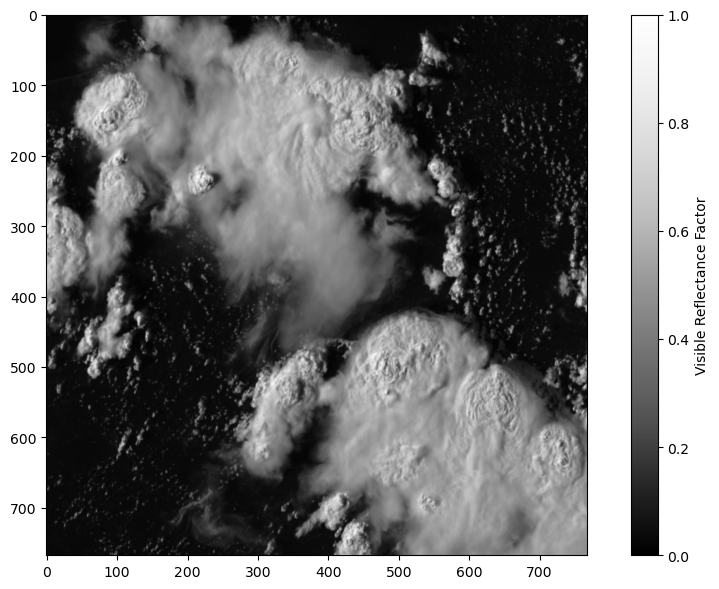

In [5]:
plt.figure(figsize=(9,6))
#show all x pixels (:) and all y pixels (:) and the first time step, with a Grey colorscale, and the color min 0 and color max 1. 
plt.imshow(ds.visible.isel(t=0)[:,:]*1e-4,cmap='Greys_r',vmin=0,vmax=1) # At timestep 0

#show us the colorbar 
plt.colorbar(label='Visible Reflectance Factor')
#a function that cleans some of the figure up. 
plt.tight_layout()

Let's Zoom in one one patch, to gain some intuition on how satellite data is used in Machine Learning (ML)

In [6]:
# Bounds on Zoom box
xmin = 278
xmax = 288

ymin= 278
ymax= 288

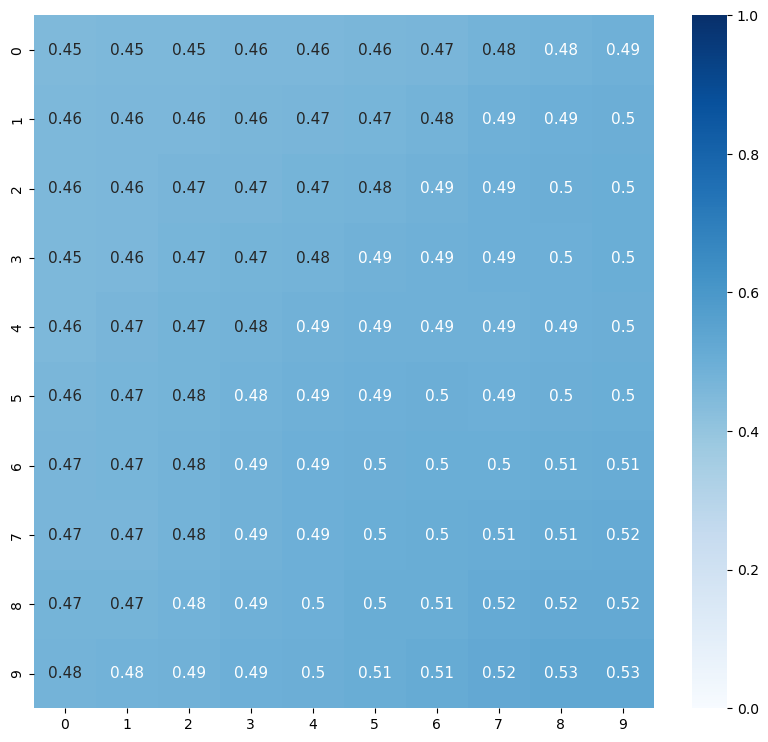

<Figure size 640x480 with 0 Axes>

In [7]:
plt.figure(figsize=(10,9))
#show all x pixels (:) and all y pixels (:) and the first time step, with a blue colorscale, and the color min 0 and color max 1. 

sns.heatmap(ds.visible[xmin:xmax,ymin:ymax,0]*1e-4, 
            cmap="Blues", 
            annot=True, 
            annot_kws={"size": 11}, # font size
            vmin=0, 
            vmax=1) 

plt.show()
plt.tight_layout()

Let's check out a small section of the lightning strike data:

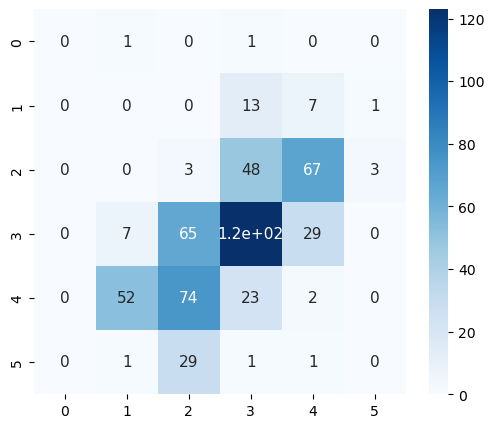

<Figure size 640x480 with 0 Axes>

In [8]:
plt.figure(figsize=(6,5))
sns.heatmap(ds.lightning_flashes.isel(t=0)[3:9,3:9], 
            cmap="Blues", 
            annot=True, 
            annot_kws={"size": 11}) # font size

plt.show()
plt.tight_layout()

After reviewing the dataset, some of the variables have different shapes:

In [9]:
print(ds.visible.shape) # x, y, time
print(ds.lightning_flashes.shape) 

(768, 768, 12)
(48, 48, 12)


# Using xESMF to regrid an xarray dataset:

Information available here: https://xesmf.readthedocs.io/en/latest/notebooks/Rectilinear_grid.html

In order to re-grid, let's set up some coordinates. Lets do some sanity checking to check what the axises needs to be divided by:

In [10]:
# Why 47 and not 48? The range for x4 is 0 to 47 (48 steps). If you divide by 48, it will be longer by ~1 in each dimmension
np.shape(ds.visible.values)[0]/47 # for both x & y, this number does not need to be an integer 

16.340425531914892

In [11]:
scaling_factor = np.shape(ds.lightning_flashes.values)

ds2 = ds.assign_coords(x4=ds.x4, y4=ds.y4, 
                        x=ds.x/16.3404, y=ds.y/16.340425, # make the coordinates match
                        time=ds.t) # making it a new dataset
ds2

<xarray.Dataset>
Dimensions:            (x: 768, y: 768, t: 12, x2: 192, y2: 192, x3: 384, y3: 384, x4: 48, y4: 48)
Coordinates:
  * x4                 (x4) int64 0 1 2 3 4 5 6 7 8 ... 40 41 42 43 44 45 46 47
  * y4                 (y4) int64 0 1 2 3 4 5 6 7 8 ... 40 41 42 43 44 45 46 47
  * x                  (x) float64 0.0 0.0612 0.1224 ... 46.82 46.88 46.94
  * y                  (y) float64 0.0 0.0612 0.1224 ... 46.82 46.88 46.94
    time               (t) int64 0 1 2 3 4 5 6 7 8 9 10 11
Dimensions without coordinates: t, x2, y2, x3, y3
Data variables:
    visible            (x, y, t) float32 242.0 234.0 ... 3.517e+03 3.238e+03
    water_vapor        (x2, y2, t) float32 ...
    clean_infrared     (x2, y2, t) float32 ...
    vil                (x3, y3, t) float32 ...
    lightning_flashes  (x4, y4, t) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    t:        time dimension of all images. These are 5-min time steps
    x:        x pixel dimension of the visible imagery
    y:        y pixel dimension of the visible imagery
    x2:       x pixel dimension of the water vapor and infrared imagery
    y2:       y pixel dimension the water vapor and infrared imagery
    x3:       x pixel dimension of the vertically integrated liquid imagery
    y3:       y pixel dimension the vertically integrated liquid imagery
    x4:       x pixel dimension of the lightning flashes
    y4:       y pixel dimension of the lightning flashes

## Decreasing visible resoultion to lighting resoultion

#### Making new datasets, this might not be required.

In [12]:
ds_visible = ds2["visible"].to_dataset()
ds_visible = ds_visible.rename({'x': 'lon','y': 'lat'})
ds_visible

<xarray.Dataset>
Dimensions:  (lon: 768, lat: 768, t: 12)
Coordinates:
  * lon      (lon) float64 0.0 0.0612 0.1224 0.1836 ... 46.76 46.82 46.88 46.94
  * lat      (lat) float64 0.0 0.0612 0.1224 0.1836 ... 46.76 46.82 46.88 46.94
    time     (t) int64 0 1 2 3 4 5 6 7 8 9 10 11
Dimensions without coordinates: t
Data variables:
    visible  (lon, lat, t) float32 242.0 234.0 236.0 ... 3.517e+03 3.238e+03

In [13]:
ds_lf = ds2["lightning_flashes"].to_dataset()
ds_lf = ds_lf.rename({'x4': 'lon',
                      'y4': 'lat'})
ds_lf 

<xarray.Dataset>
Dimensions:            (lon: 48, lat: 48, t: 12)
Coordinates:
  * lon                (lon) int64 0 1 2 3 4 5 6 7 8 ... 40 41 42 43 44 45 46 47
  * lat                (lat) int64 0 1 2 3 4 5 6 7 8 ... 40 41 42 43 44 45 46 47
    time               (t) int64 0 1 2 3 4 5 6 7 8 9 10 11
Dimensions without coordinates: t
Data variables:
    lightning_flashes  (lon, lat, t) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [14]:
regridder = xe.Regridder(ds_visible, ds_lf, "bilinear")
regridder  # print basic regridder information.

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_768x768_48x48.nc 
Reuse pre-computed weights? False 
Input grid shape:           (768, 768) 
Output grid shape:          (48, 48) 
Periodic in longitude?      False

In [15]:
dr_out = regridder(ds_visible)
dr_out

/Users/tmartin/opt/anaconda3/envs/ml_scratch/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


<xarray.Dataset>
Dimensions:  (t: 12, lat: 48, lon: 48)
Coordinates:
    time     (t) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 9 ... 38 39 40 41 42 43 44 45 46 47
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 9 ... 38 39 40 41 42 43 44 45 46 47
Dimensions without coordinates: t
Data variables:
    visible  (t, lat, lon) float32 242.0 241.0 241.0 235.1 ... 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

### Direct Comparison

Note the difference in x & y axis

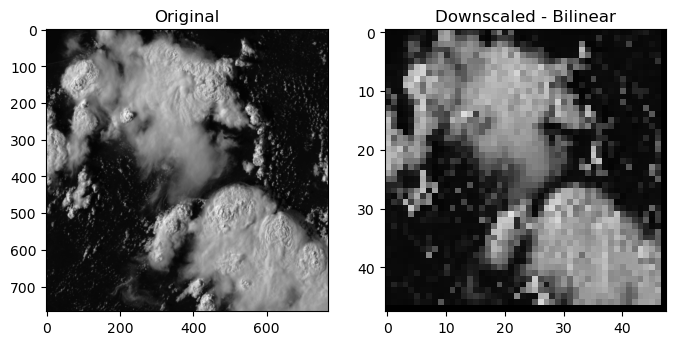

In [16]:
time_step = 0

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(8,8))
# Original figure
ax1.imshow(ds.visible.isel(t=time_step)[:,:]*1e-4,cmap='Greys_r',vmin=0,vmax=1) # the x and y axis were flipped, added the .T to fix the plot
ax1.title.set_text('Original')

ax2.imshow(dr_out.visible.isel(t=time_step)[:,:].T*1e-4,cmap='Greys_r',vmin=0,vmax=1) 
ax2.title.set_text('Downscaled - Bilinear')

## We can also upscale low-resoultion data

Note: This is not a reccomendation to do this for every workflow/dataset! There are five different algorithms that you can use, here is a nice comparison: https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html

In [17]:
regridder_up_con = xe.Regridder(ds_lf, ds_visible, "conservative") #note different method from before
regridder_up_patch = xe.Regridder(ds_lf, ds_visible, "patch") 
regridder_up_patch  # print basic regridder information.

xESMF Regridder 
Regridding algorithm:       patch 
Weight filename:            patch_48x48_768x768.nc 
Reuse pre-computed weights? False 
Input grid shape:           (48, 48) 
Output grid shape:          (768, 768) 
Periodic in longitude?      False

In [18]:
upscaled_lf_con = regridder_up_con(ds_lf)
upscaled_lf_patch = regridder_up_patch(ds_lf)

/Users/tmartin/opt/anaconda3/envs/ml_scratch/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


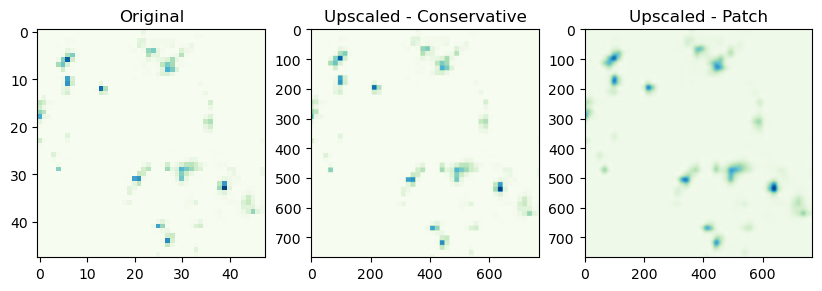

In [19]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(10,4))

# Original Dataset
ax1.imshow(ds.lightning_flashes.isel(t=0)[:,:],cmap='GnBu')
ax1.title.set_text('Original')


ax2.imshow(upscaled_lf_con.lightning_flashes.isel(t=0)[:,:].T, cmap='GnBu')
ax2.title.set_text('Upscaled - Conservative')

ax3.imshow(upscaled_lf_patch.lightning_flashes.isel(t=0)[:,:].T, cmap='GnBu')
ax3.title.set_text('Upscaled - Patch')

# Merging Xarray Datasets

After you have made a new grid, you will want to combine them into a new xarray dataset for future analysis. Here is an example using combine by coords:

In [20]:
upscaled_lf_patch

<xarray.Dataset>
Dimensions:            (t: 12, lat: 768, lon: 768)
Coordinates:
    time               (t) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * lon                (lon) float64 0.0 0.0612 0.1224 ... 46.82 46.88 46.94
  * lat                (lat) float64 0.0 0.0612 0.1224 ... 46.82 46.88 46.94
Dimensions without coordinates: t
Data variables:
    lightning_flashes  (t, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  patch

In [21]:
ds_visible

<xarray.Dataset>
Dimensions:  (lon: 768, lat: 768, t: 12)
Coordinates:
  * lon      (lon) float64 0.0 0.0612 0.1224 0.1836 ... 46.76 46.82 46.88 46.94
  * lat      (lat) float64 0.0 0.0612 0.1224 0.1836 ... 46.76 46.82 46.88 46.94
    time     (t) int64 0 1 2 3 4 5 6 7 8 9 10 11
Dimensions without coordinates: t
Data variables:
    visible  (lon, lat, t) float32 242.0 234.0 236.0 ... 3.517e+03 3.238e+03

In [22]:
new_dataset = xr.combine_by_coords([upscaled_lf_patch, ds_visible])
new_dataset

<xarray.Dataset>
Dimensions:            (t: 12, lat: 768, lon: 768)
Coordinates:
    time               (t) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * lon                (lon) float64 0.0 0.0612 0.1224 ... 46.82 46.88 46.94
  * lat                (lat) float64 0.0 0.0612 0.1224 ... 46.82 46.88 46.94
Dimensions without coordinates: t
Data variables:
    lightning_flashes  (t, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    visible            (lon, lat, t) float32 242.0 234.0 ... 3.517e+03 3.238e+03
Attributes:
    regrid_method:  patch

## Summary

This has been a quick introduction to useing the xESMF regridding tools! The documentation for xESMF & xarray are very helpful for future learning.